In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import random
from statsmodels.stats.power import tt_ind_solve_power

def date_converter(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

### Задание 3
**Срок сдачи: 07 апреля 18:00**

В этом задание вы будете работать с выручкой - метрикой с достаточно высокой дисперсией и соответсвенно низкой чувствительностью к изменениям.

Вам предстоит разработать подход по повышению чувствительности этой метрики.
От успеха данной инициативы зависит то, как быстро мы сможем проверять продуктовые гипотезы.

#### Для планирования эксперимента изучите данные и метрики 2 балла:

- Загрузите файл и изучите данные;
- Изучите основные статистики метрики: среднее, стандартное отклонение;
- Изучите то, как эти статистики изменяются внутри срезов: user_segment, region, category

#### Предскажите минимально детектируемый эффект (MDE) 2 балла:

- Для размеров тестовых групп 10,25,50% и длительностей 30, 60, 90 дней предскажите минимально детектируемый эффект;


#### CUPED 6 баллов
Разработайте подход по снижению дисперсии на основе методики CUPED:

- Рассчитайте CUPED метрику на основе данных за периода в 30 дней перед предполагаемым периодом сбора основной выборки и опишите как изменился MDE для выборок 50/50%, собранных за 30 дней (2 бала). 
- Проверьте насколько данный подход подвержен сезональности. Как меняется MDE, если применять данный подход в разные периоды (2 бала). 
- Оптимизируйте подход варьируя количество дней до теста, которые вы будете для расчёта CUPED метрики. Какое максимальное снижение MDE вы смогли достичь (2 бала).



#### * Стратификация 4 балла (задание для получения дополнительных баллов)
Разработайте подход по снижению дисперсии на основе методики стратификации выборок:

- Стратифицируйте выборки внутри срезов user_segment, region, category
- Рассчитайте стратифицированные среднее,стандартное отклонение для этих выборок и MDE для теста 50/50% длительностью 30 дней.
- В каких срезах достигается наибольшее снижение MDE?



#### Описание данныx

event_date - дата 

user_id - идентификатор пользователя

user_segment - сегмент пользователей

region - регион

category - категория авито

revenue_amount - сумма покупок


In [199]:
df = pd.read_csv('user_amount_var_reduction.csv')
df['event_date']=df.event_date.apply(date_converter)

In [200]:
df

,event_date,user_id,user_segment,category,region,revenue_amount
0,2019-06-18,4129257975403696,4626944681007198896,7204754148424990691,2201388710798473628,139
1,2019-06-18,7225254357470025,4626944681007198896,57514010642945023,3048517866726460689,193
2,2019-06-18,8912846500600569,4626944681007198896,5983323600580891431,3048517866726460689,160
3,2019-06-18,20910801279823046,4626944681007198896,6847326422676498281,7762196236856042106,209
4,2019-06-18,34873300821657220,2376074197230840906,3187769798308634693,3855810523611026650,160
...,...,...,...,...,...,...
8625837,2019-12-08,9170823997728769058,2376074197230840906,4658595883120885993,3855810523611026650,133
8625838,2019-12-08,9178869387857307556,4626944681007198896,1472231361867825698,3048517866726460689,63
8625839,2019-12-08,9186690404771258365,2376074197230840906,4546178272531746227,8867014108346120905,168
8625840,2019-12-08,9195678548159495844,2376074197230840906,5983323600580891431,1187552825302355021,118


In [114]:
df_group_user_id = df.groupby(['user_id']).revenue_amount.sum()

In [115]:
df_group_user_id = df_group_user_id.reset_index()

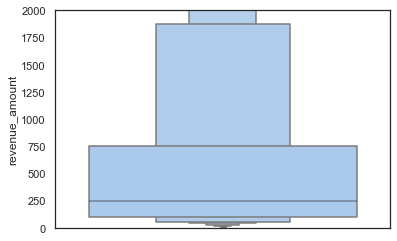

In [118]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))

sns.boxenplot(y= df_group_user_id.revenue_amount, palette='pastel',
            ax=ax)
ax.set(ylim = (0,2000));

на графике видно что распределение имеет большой разброс(более 12 процентов больше 1750)

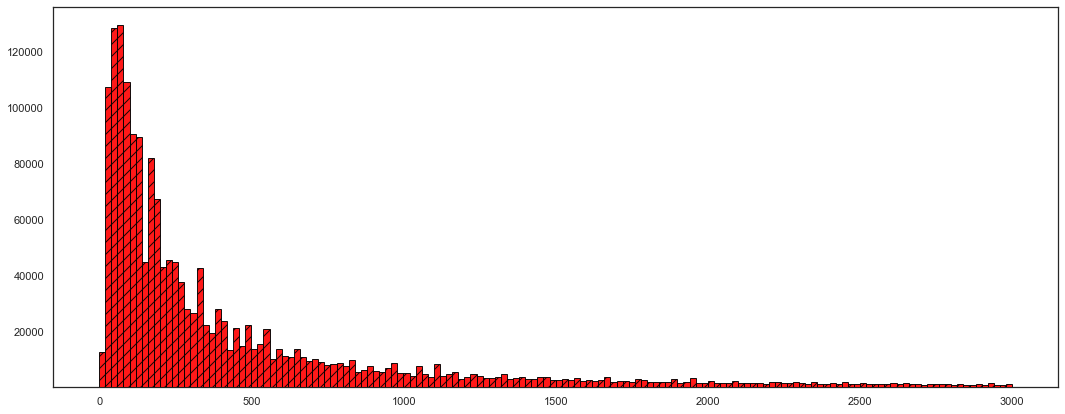

In [119]:
fig, ax = plt.subplots(figsize = (18, 7))
ax.hist(df_group_user_id.revenue_amount , bins = 150, # bins - целое число, оно определяет количество интервалов одинаковой ширины в диапазоне
        zorder = 3, range = (-1, 3000), # Нижние и верхние выбросы игнорируются? если не указан, диапазон равен (x.min (), x.max ())
        density = False,  # density = True - нормировка по оси y прощади на 1
        alpha = 0.9,
        bottom = 0.2, # смещение на 0.2 вверх
        rwidth = 1, # толщина столбца rwidth
        color = 'red', # цвет столбца
        edgecolor = 'black', # цвет края
        hatch = '//'); # hatch - штриховка

In [120]:
print('Mean =',int(df_group_user_id.revenue_amount.mean()))
print('Median =',int(df_group_user_id.revenue_amount.median()))
print('std =',int(df_group_user_id.revenue_amount.std()))
print('----------------')
print('Percentile_5 =',int(np.percentile(df_group_user_id.revenue_amount, q = 5)))
print('Percentile_95 =',int(np.percentile(df_group_user_id.revenue_amount, q = 95)))

Mean = 1789
Median = 245
std = 19499
----------------
Percentile_5 = 35
Percentile_95 = 5345


[(0.0, 2500.0)]

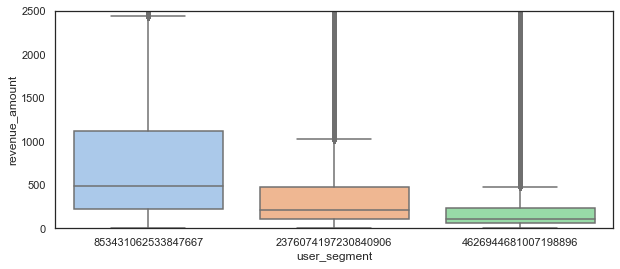

In [121]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))

sns.boxplot(x= 'user_segment', y = 'revenue_amount', palette='pastel',
            ax=ax, data = df)
ax.set(ylim = (0,2500))

Распределение сильно зависит от 'user_segment'

[(0.0, 1000.0)]

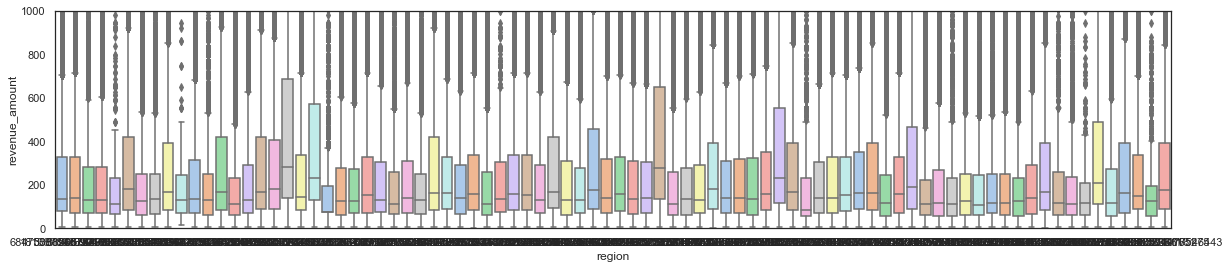

In [122]:
fig, ax = plt.subplots(1, 1, figsize = (20, 4))

sns.boxplot(x= 'region', y = 'revenue_amount', palette='pastel',
            ax=ax, data = df)
ax.set(ylim = (0,1000))

[(0.0, 2500.0)]

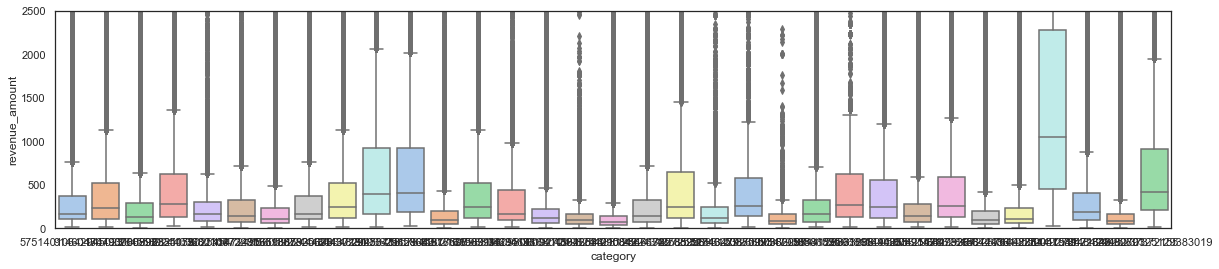

In [124]:
fig, ax = plt.subplots(1, 1, figsize = (20, 4))

sns.boxplot(x= 'category', y = 'revenue_amount', palette='pastel',
            ax=ax, data = df)
ax.set(ylim = (0,2500))

имеется большое количество групп по 'category' и 'region' которые имеют довольно отличные распределения, этим можно воспользововаться для стратификации

In [125]:
def choose_date(data, start_date, delta, share): 
    tmp = data[(data.event_date>=start_date)&(data.event_date<=start_date+datetime.timedelta(days=delta))]
    tmp=tmp.groupby(['user_id']).sum().reset_index()
    x = tmp[(tmp.user_id)%100<=100*share].reset_index()
    return x

In [203]:
print('Детектируемый эффект с точностью до сотых в зависимости от доли и длительности эксперимента:')
print()

for dolya in [0.1, 0.25, 0.5]:
    for duration in [30, 60, 90]:
        x1 =choose_date(df, datetime.datetime(2019, 8, 1, 0, 0), duration, dolya) #получаем необходимую подвыборку

        from statsmodels.stats.power import tt_ind_solve_power

        mean = x1.revenue_amount.mean()
        std = x1.revenue_amount.std()

        alpha = 0.01
        power = 0.8
        result_effect = 0.01
        
        effect_size = (mean /std) * result_effect
        sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')

        
        while sample_vol > x1.shape[0]:
            result_effect += 0.01 # целевой размер относительного отклоенения исходной метрики
            effect_size = (mean /std) * result_effect
            sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')
        
        print('Доля=', dolya, end = ' ')
        print('Длительность=', duration, end = ' -> ')
        print('Детектируемый эффект:', np.round(result_effect, 2))
#       print(sample_vol/x1.shape[0])# получаем множитель того, во сколько раз необходимо изменить размер выборки

Детектируемый эффект с точностью до сотых в зависимости от доли и длительности эксперимента:

Доля= 0.1 Длительность= 30 -> Детектируемый эффект: 0.13
Доля= 0.1 Длительность= 60 -> Детектируемый эффект: 0.13
Доля= 0.1 Длительность= 90 -> Детектируемый эффект: 0.13
Доля= 0.25 Длительность= 30 -> Детектируемый эффект: 0.11
Доля= 0.25 Длительность= 60 -> Детектируемый эффект: 0.1
Доля= 0.25 Длительность= 90 -> Детектируемый эффект: 0.09
Доля= 0.5 Длительность= 30 -> Детектируемый эффект: 0.07
Доля= 0.5 Длительность= 60 -> Детектируемый эффект: 0.06
Доля= 0.5 Длительность= 90 -> Детектируемый эффект: 0.06


ожидаемо увеличение доли и длительности улучшает результат для детектирования

**cuped**

In [202]:
#функция которая собирает данные за предпериод 
def choose_date2(data, start_date, delta): 
    tmp = data[(data.event_date>=start_date)&(data.event_date<=start_date+datetime.timedelta(days=delta))]
    tmp=tmp.groupby(['user_id']).sum().reset_index()
    x = tmp.reset_index()
    return x

In [154]:
print('Детектируемый эффект при использовании cuped с точностью до сотых в зависимости от доли и длительности эксперимента:')
print()

for dolya in [0.1, 0.25, 0.5]:
    for duration in [30]:
        x1 =choose_date(df, datetime.datetime(2019, 8, 18, 0, 0), duration, dolya) #получаем необходимую подвыборку
        x2 = choose_date2(df, datetime.datetime(2019, 7, 18 , 0, 0), 30)
        
        #считаем pre_revenue_amount 
        ww = x1.merge(x2, left_on = 'user_id', right_on='user_id', how = 'left')[['user_id', 'revenue_amount_x', 'revenue_amount_y']]
        ww.rename(columns={"revenue_amount_x": "revenue_amount", "revenue_amount_y": "pre_revenue_amount"}, inplace = True)
        ww['pre_revenue_amount'] = ww['pre_revenue_amount'].fillna(0)
        ww
        
        #cuped
        ww['pre_revenue_tg_average']=ww.pre_revenue_amount.mean() 
        teta = np.cov(ww.revenue_amount, ww.pre_revenue_amount, ddof=1)[1,0]/np.var(ww.pre_revenue_amount, ddof=1)
        corr = np.corrcoef(ww.revenue_amount, ww.pre_revenue_amount)[1,0] 
        ww['cuped_revenue'] = ww.revenue_amount - teta * (ww.pre_revenue_amount - ww.pre_revenue_tg_average)
        
        
        from statsmodels.stats.power import tt_ind_solve_power

        mean = ww.cuped_revenue.mean()
        std = ww.cuped_revenue.std()

        alpha = 0.01
        power = 0.8
        result_effect = 0.01
        
        effect_size = (mean /std) * result_effect
        sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')

        
        while sample_vol > x1.shape[0]:
            result_effect += 0.01 # целевой размер относительного отклоенения исходной метрики
            effect_size = (mean /std) * result_effect
            sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')
        
        print('Доля=', dolya, end = ' ')
        print('Длительность=', duration, end = ' -> ')
        print('Детектируемый эффект:', np.round(result_effect, 2))
#       print(sample_vol/x1.shape[0])# получаем множитель того, во сколько раз необходимо изменить размер выборки

Детектируемый эффект при использовании cuped с точностью до сотых в зависимости от доли и длительности эксперимента:

Доля= 0.1 Длительность= 30 -> Детектируемый эффект: 0.05
Доля= 0.25 Длительность= 30 -> Детектируемый эффект: 0.04
Доля= 0.5 Длительность= 30 -> Детектируемый эффект: 0.03


Cuped заметно(в два и более раза снижает тот эффект который мы можем задетектировать) 

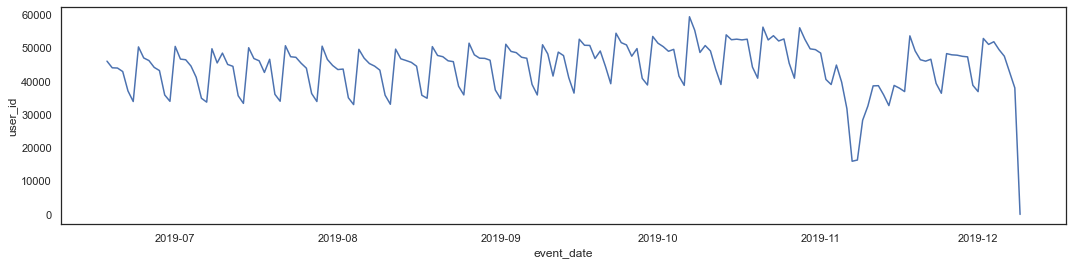

In [159]:
s_day = df.groupby(['event_date']).user_id.nunique()
s_day = s_day.reset_index()

fig, ax = plt.subplots(1, 1, figsize = (18, 4))
sns.lineplot(x = 'event_date', y = 'user_id', ax = ax, data = s_day);

Видно что распределение числа участников имеет какой то переодический характер с непонятным провалов в ноябре, поэтомы мы можем подбирать время для эксперимента, чтобы как можно больше участников попало в него за тоже время

In [169]:
print('Детектируемый эффект при использовании cuped с точностью до сотых в зависимости от месяца и даты при разбиении 50/50% и длительности 30days:')
print()

for month in [8, 9, 10, 11]:
    print('------------')
    print('Month=', month)
    for day in [1, 15, 30]:
        print('start day=', day, end = ' -> ')
        for dolya in [0.5]:
            for duration in [30]:
                x1 =choose_date(df, datetime.datetime(2019, month, day, 0, 0), duration, dolya) #получаем необходимую подвыборку
                x2 = choose_date2(df, datetime.datetime(2019, month - 1, day, 0, 0), 30)

                #считаем pre_revenue_amount 
                ww = x1.merge(x2, left_on = 'user_id', right_on='user_id', how = 'left')[['user_id', 'revenue_amount_x', 'revenue_amount_y']]
                ww.rename(columns={"revenue_amount_x": "revenue_amount", "revenue_amount_y": "pre_revenue_amount"}, inplace = True)
                ww['pre_revenue_amount'] = ww['pre_revenue_amount'].fillna(0)
                ww

                #cuped
                ww['pre_revenue_tg_average']=ww.pre_revenue_amount.mean() 
                teta = np.cov(ww.revenue_amount, ww.pre_revenue_amount, ddof=1)[1,0]/np.var(ww.pre_revenue_amount, ddof=1)
                corr = np.corrcoef(ww.revenue_amount, ww.pre_revenue_amount)[1,0] 
                ww['cuped_revenue'] = ww.revenue_amount - teta * (ww.pre_revenue_amount - ww.pre_revenue_tg_average)


                from statsmodels.stats.power import tt_ind_solve_power

                mean = ww.cuped_revenue.mean()
                std = ww.cuped_revenue.std()

                alpha = 0.01
                power = 0.8
                result_effect = 0.01

                effect_size = (mean /std) * result_effect
                sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')


                while sample_vol > x1.shape[0]:
                    result_effect += 0.01 # целевой размер относительного отклоенения исходной метрики
                    effect_size = (mean /std) * result_effect
                    sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')

#                print('Доля=', dolya, end = ' ')
#                print('Длительность=', duration, end = ' -> ')
                print('Детектируемый эффект:', np.round(result_effect, 2))
        #       print(sample_vol/x1.shape[0])# получаем множитель того, во сколько раз необходимо изменить размер выборки

Детектируемый эффект при использовании cuped с точностью до сотых в зависимости от месяца и даты при разбиении 50/50% и длительности 30days:

------------
Month= 8
start day= 1 -> Детектируемый эффект: 0.04
start day= 15 -> Детектируемый эффект: 0.03
start day= 30 -> Детектируемый эффект: 0.03
------------
Month= 9
start day= 1 -> Детектируемый эффект: 0.03
start day= 15 -> Детектируемый эффект: 0.03
start day= 30 -> Детектируемый эффект: 0.03
------------
Month= 10
start day= 1 -> Детектируемый эффект: 0.03
start day= 15 -> Детектируемый эффект: 0.04
start day= 30 -> Детектируемый эффект: 0.03
------------
Month= 11
start day= 1 -> Детектируемый эффект: 0.03
start day= 15 -> Детектируемый эффект: 0.03
start day= 30 -> Детектируемый эффект: 0.03


Видно что есть небольшой разброс, благодаря которому мы можем выделять более удачное время для проведения эксперимента

In [189]:
print('Детектируемый эффект при использовании cuped с точностью до сотых в зависимости количества дней между сбором данных для pre и   теста, при разбиении 50/50% и длительности 30days:')
print()

for month in [11, 10, 9, 8]:
    for day in [15, 30]:
        if month == 11 and day == 15:
            print()
        else:
            print('Сбор через',day - 30 + 30*(11 - month), 'days', end = ' -> ')

            for dolya in [0.5]:
                for duration in [30]:
                    x1 =choose_date(df, datetime.datetime(2019, 11, 1, 0, 0), duration, dolya) #получаем необходимую подвыборку
                    x2 = choose_date2(df, datetime.datetime(2019, month - 1, 31 - day, 0, 0), 30)

                    #считаем pre_revenue_amount 
                    ww = x1.merge(x2, left_on = 'user_id', right_on='user_id', how = 'left')[['user_id', 'revenue_amount_x', 'revenue_amount_y']]
                    ww.rename(columns={"revenue_amount_x": "revenue_amount", "revenue_amount_y": "pre_revenue_amount"}, inplace = True)
                    ww['pre_revenue_amount'] = ww['pre_revenue_amount'].fillna(0)
                    ww

                    #cuped
                    ww['pre_revenue_tg_average']=ww.pre_revenue_amount.mean() 
                    teta = np.cov(ww.revenue_amount, ww.pre_revenue_amount, ddof=1)[1,0]/np.var(ww.pre_revenue_amount, ddof=1)
                    corr = np.corrcoef(ww.revenue_amount, ww.pre_revenue_amount)[1,0] 
                    ww['cuped_revenue'] = ww.revenue_amount - teta * (ww.pre_revenue_amount - ww.pre_revenue_tg_average)


                    from statsmodels.stats.power import tt_ind_solve_power

                    mean = ww.cuped_revenue.mean()
                    std = ww.cuped_revenue.std()

                    alpha = 0.01
                    power = 0.8
                    result_effect = 0.01

                    effect_size = (mean /std) * result_effect
                    sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')


                    while sample_vol > x1.shape[0]:
                        result_effect += 0.01 # целевой размер относительного отклоенения исходной метрики
                        effect_size = (mean /std) * result_effect
                        sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')

    #                print('Доля=', dolya, end = ' ')
    #                print('Длительность=', duration, end = ' -> ')
                    print('Детектируемый эффект:', np.round(result_effect, 2))
            #       print(sample_vol/x1.shape[0])# получаем множитель того, во сколько раз необходимо изменить размер выборки

Детектируемый эффект при использовании cuped с точностью до сотых в зависимости количества дней между сбором данных для pre и      теста, при разбиении 50/50% и длительности 30days:


Сбор через 0 days -> Детектируемый эффект: 0.03
Сбор через 15 days -> Детектируемый эффект: 0.04
Сбор через 30 days -> Детектируемый эффект: 0.04
Сбор через 45 days -> Детектируемый эффект: 0.04
Сбор через 60 days -> Детектируемый эффект: 0.04
Сбор через 75 days -> Детектируемый эффект: 0.05
Сбор через 90 days -> Детектируемый эффект: 0.05


Тут наблюдается зависимость, что чем дальше разнемены наши данные на pred periode и тест тем сложнее задетектировать эффект, это может быть связано с плотностью покупок, т.е людип покупают чаще в опеределенный период или с тем что немного меняется поведение людей -> снижается ковариация -> хуже детектируется

**Стратификация**

#немного не успел(